In [1]:
import seaborn as sns
from rich import print, inspect, traceback, pretty
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colormaps as cmaps

import cartopy.crs as ccrs

from chaotic_carbon_networks import ROOT
from chaotic_carbon_networks import matrix as ccnm
from chaotic_carbon_networks.preprocessing import concat_airs_data, concat_graced_data
from chaotic_carbon_networks.viz import plot_world, plot_matrix, plot_world_to_axis
from chaotic_carbon_networks.anomaly_correction import anomaly_correction_month, anomaly_correction_week
from chaotic_carbon_networks.hex import hexgrid, filledgrid_from_hexgrid
from chaotic_carbon_networks.masks import mask_population, mask_poles
from chaotic_carbon_networks.analysis import double_dataset, single_dataset
from chaotic_carbon_networks.matrix import (
    laged_pearson_similarity_matrix,
    mutual_information_matrix,
    adjacency_matrix,
    link_lengths_like,
    degrees,
    average_link_length,
    betweenness
)

FIGURE_PATH = ROOT / "figures" / "paper"
FIGURE_PATH.mkdir(parents=True, exist_ok=True)

sns.set_theme(context='paper', style="whitegrid", palette="Set2", font_scale=1.5, rc={'figure.figsize':(9,6)})
pretty.install()
traceback.install(show_locals=False)

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f7bc733bed0>>

## Hex vs NoHex

Loading cached data from /home/tobias/Repositories/chaotic-carbon-networks/data/aqua-airs/cache/aqua_airs_concat.nc

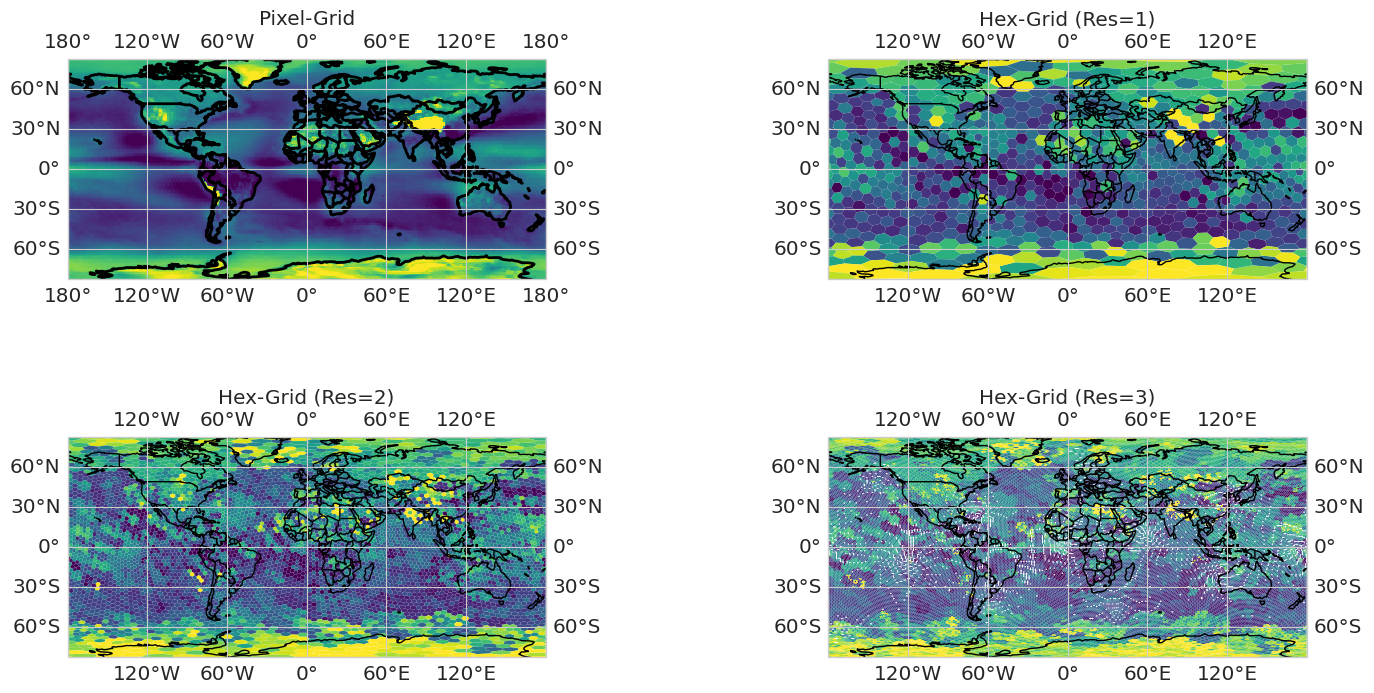

In [5]:
co2 = concat_airs_data()["co2_vmr_uppertrop"].sel(orbit_pass="13:30:00")
co2_hex = hexgrid(co2, hex_res=1)
co2_hex2 = hexgrid(co2, hex_res=2)
co2_hex3 = hexgrid(co2, hex_res=3)

fig, axs = plt.subplots(2, 2,
                        sharey=True,
                        subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)},
                        figsize=(18, 9))
axs = axs.flatten()
plot_world_to_axis(co2.mean("time", keep_attrs=True), ax=axs[0])
plot_world_to_axis(co2_hex.mean("time", keep_attrs=True), ax=axs[1])
plot_world_to_axis(co2_hex2.mean("time", keep_attrs=True), ax=axs[2])
plot_world_to_axis(co2_hex3.mean("time", keep_attrs=True), ax=axs[3])
axs[0].set_title("Pixel-Grid")
axs[1].set_title("Hex-Grid (Res=1)")
axs[2].set_title("Hex-Grid (Res=2)")
axs[3].set_title("Hex-Grid (Res=3)")
fig.delaxes(fig.axes[4])
fig.delaxes(fig.axes[4])
fig.delaxes(fig.axes[4])
fig.delaxes(fig.axes[4])

fig.savefig(FIGURE_PATH / "hex-vs-nonhex.svg")
fig.savefig(FIGURE_PATH / "hex-vs-nonhex.jpg")

Loading cached data from /home/tobias/Repositories/chaotic-carbon-networks/data/aqua-airs/cache/aqua_airs_concat.nc

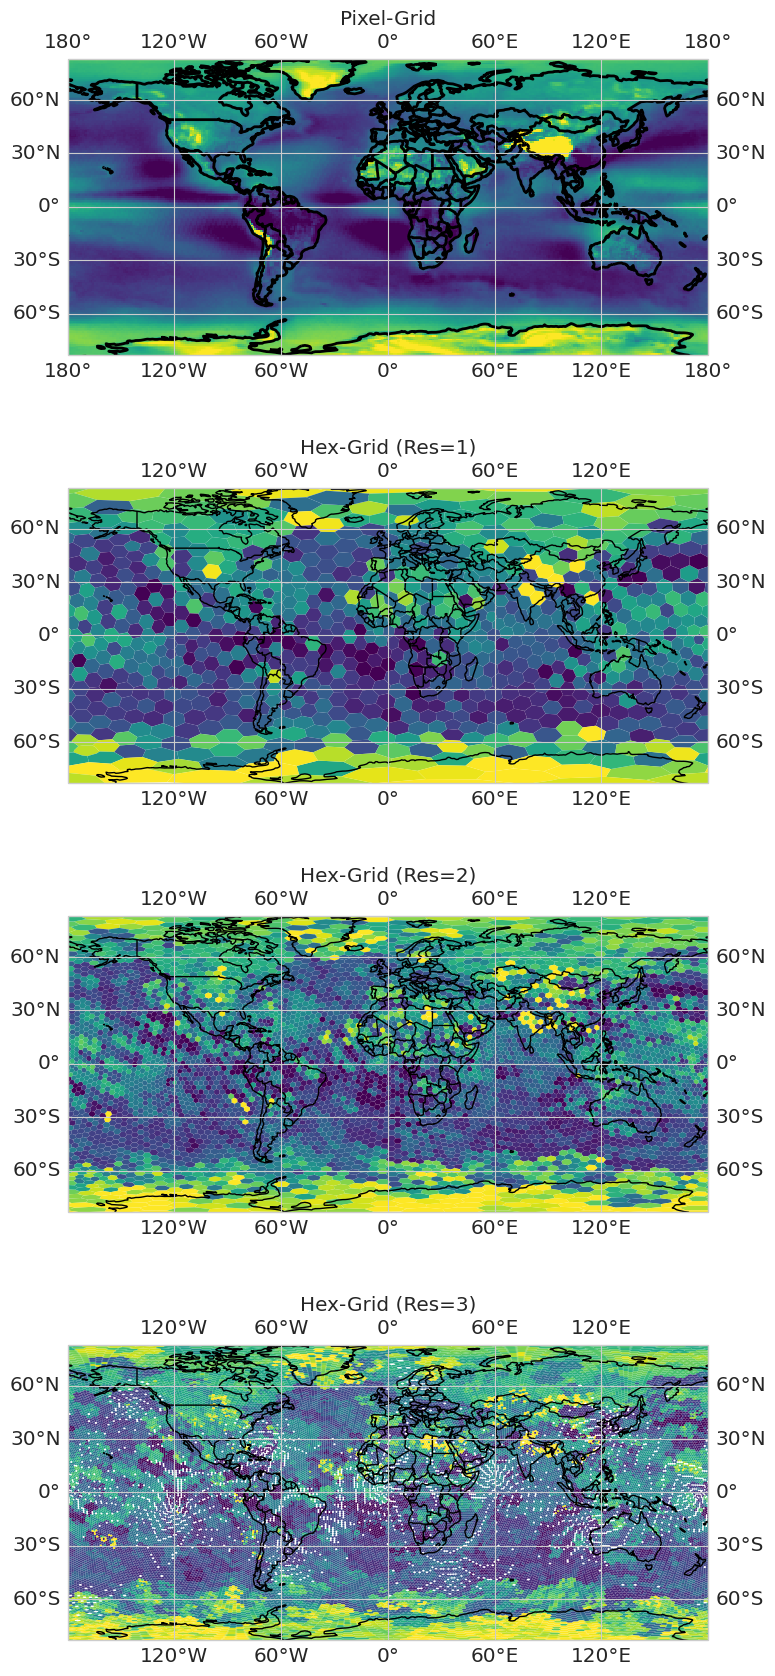

In [4]:
co2 = concat_airs_data()["co2_vmr_uppertrop"].sel(orbit_pass="13:30:00")
co2_hex = hexgrid(co2, hex_res=1)
co2_hex2 = hexgrid(co2, hex_res=2)
co2_hex3 = hexgrid(co2, hex_res=3)

fig, axs = plt.subplots(4, 1,
                        sharey=True,
                        subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)},
                        figsize=(9, 18))
axs = axs.flatten()
plot_world_to_axis(co2.mean("time", keep_attrs=True), ax=axs[0])
plot_world_to_axis(co2_hex.mean("time", keep_attrs=True), ax=axs[1])
plot_world_to_axis(co2_hex2.mean("time", keep_attrs=True), ax=axs[2])
plot_world_to_axis(co2_hex3.mean("time", keep_attrs=True), ax=axs[3])
axs[0].set_title("Pixel-Grid")
axs[1].set_title("Hex-Grid (Res=1)")
axs[2].set_title("Hex-Grid (Res=2)")
axs[3].set_title("Hex-Grid (Res=3)")
fig.delaxes(fig.axes[4])
fig.delaxes(fig.axes[4])
fig.delaxes(fig.axes[4])
fig.delaxes(fig.axes[4])

fig.tight_layout()

fig.savefig(FIGURE_PATH / "hex-vs-nonhex-col.svg")
fig.savefig(FIGURE_PATH / "hex-vs-nonhex-col.jpg")

In [3]:
del co2, co2_hex, co2_hex2, co2_hex3, fig, axs

## Over Time

In [72]:
co2_graced_diff = concat_graced_data(5, method="sum")
co2_graced = mask_population(co2_graced_diff, threshold=0)
co2_graced = hexgrid(co2_graced, method="sum", hex_res=3)
#co2_graced = co2_graced.resample(time='1MS').sum(dim='time')
co2_graced = co2_graced.dropna("time", how="all")
co2_graced = co2_graced.cumsum("time", keep_attrs=True)
#co2_graced = anomaly_correction_month(co2_graced)

co2_airs = concat_airs_data()["co2_vmr_uppertrop"].sel(orbit_pass="13:30:00")
co2_airs_diff = co2_airs.diff("time")
co2_airs_diff.attrs = co2_airs.attrs
co2_airs_diff = co2_airs_diff.sel(time=co2_graced.time, method="nearest")
co2_airs = hexgrid(co2_airs, method="mean", hex_res=2)
#co2_airs = anomaly_correction_month(co2_airs)
co2_airs = co2_airs.sel(time=co2_graced.time, method="nearest")

Loading cached data from 
/home/tobias/Repositories/chaotic-carbon-networks/data/graced/cache/graced_co2_concat_5x_sumed.nc

Loading cached population data from 
/home/tobias/Repositories/chaotic-carbon-networks/data/population/cache/GHS_POP_E2020_GLOBE_R2023A_4326_30ss_V1_0_r
esampled_0.50deg.nc

Loading cached data from /home/tobias/Repositories/chaotic-carbon-networks/data/aqua-airs/cache/aqua_airs_concat.nc

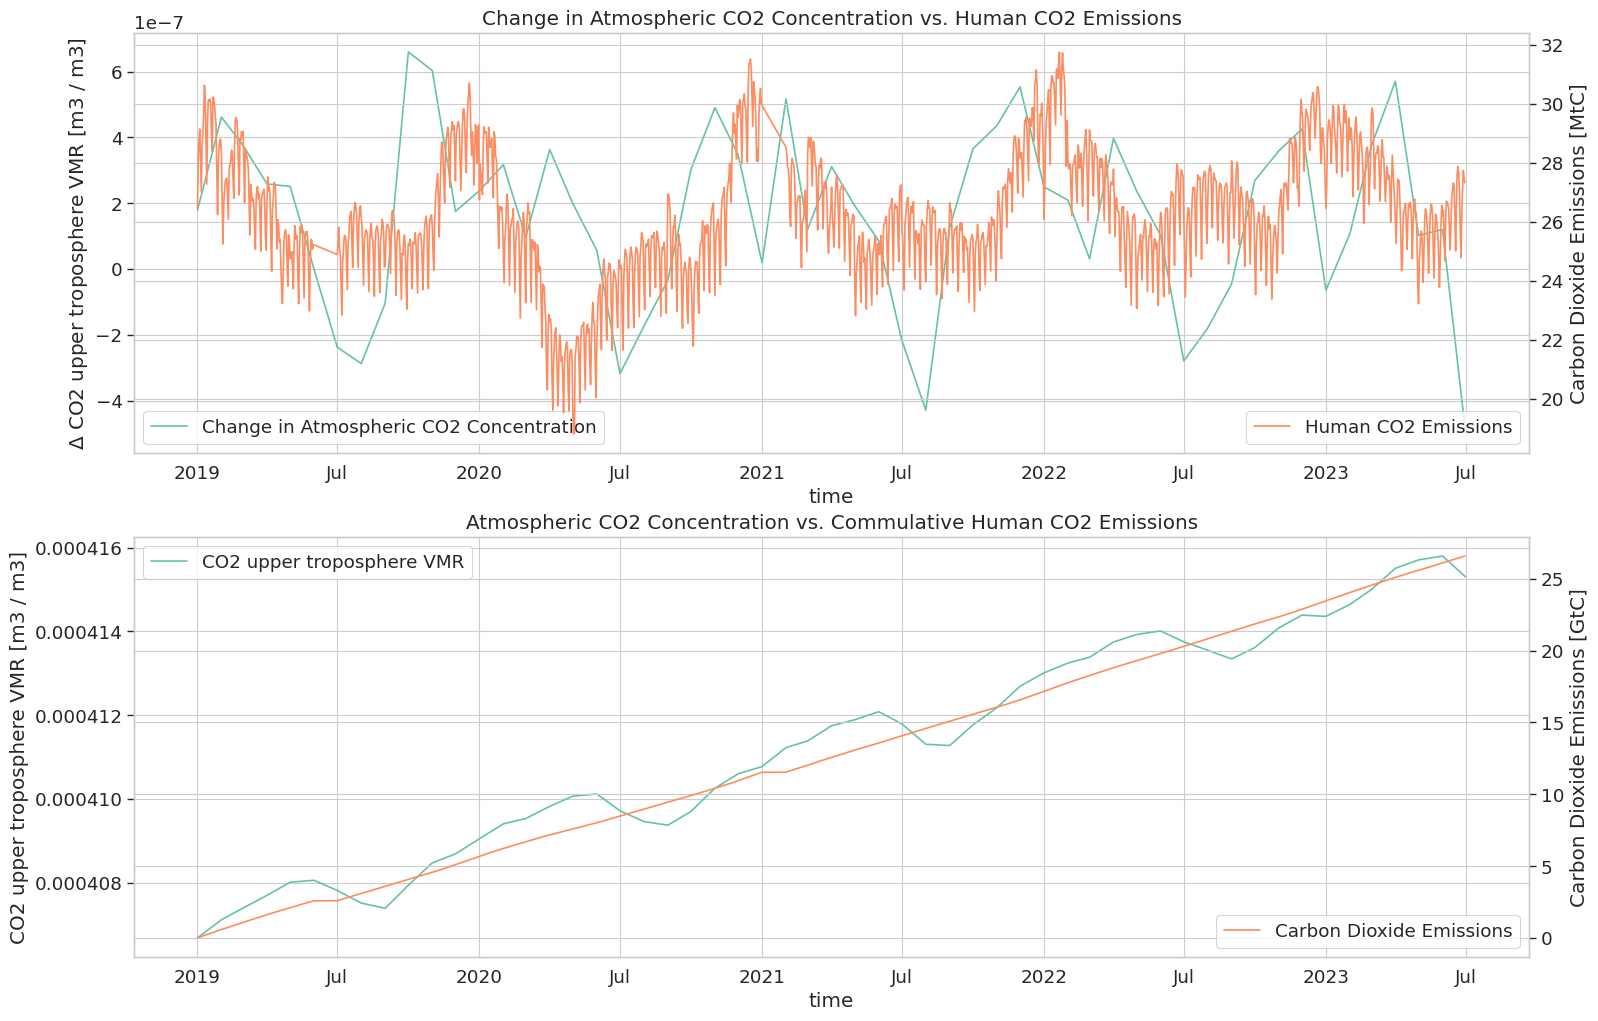

In [73]:
fig, axs = plt.subplots(2, 1, figsize=(18, 12))
axs2 = [axs[0].twinx(), axs[1].twinx()]
palette = sns.color_palette("Set2", 2)

co2_airs_diff.mean(dim=["lat", "lon"]).plot(ax=axs[0], label="Change in Atmospheric CO2 Concentration", c=palette[0])
(co2_graced_diff.sum(dim=["lat", "lon"]) / 1000 / 1000 / 1000).plot(ax=axs2[0], label="Human CO2 Emissions", c=palette[1])
axs[0].legend(loc="lower left")
axs2[0].legend(loc="lower right")

co2_airs.mean(dim="vertex").plot(ax=axs[1], label=co2_airs.long_name, c=palette[0])
(co2_graced.sum(dim="vertex") / 1000 / 1000 / 1000 / 1000).plot(ax=axs2[1], label=co2_graced.long_name, c=palette[1])
axs[1].legend(loc="upper left")
axs2[1].legend(loc="lower right")

axs[0].set_title("Change in Atmospheric CO2 Concentration vs. Human CO2 Emissions")
axs2[0].set_title("")
axs[1].set_title("Atmospheric CO2 Concentration vs. Commulative Human CO2 Emissions")
axs2[1].set_title("")

axs[0].set_ylabel(rf"$\Delta$ {co2_airs.long_name} [{co2_airs.units}]")
axs2[0].set_ylabel(co2_graced.long_name + f" [MtC]")
axs[1].set_ylabel(f"{co2_airs.long_name} [{co2_airs.units}]")
axs2[1].set_ylabel(co2_graced.long_name + f" [GtC]")

fig.savefig(FIGURE_PATH / "over-time.svg")

In [74]:
co2_graced = concat_graced_data(5, method="sum")
co2_graced = mask_population(co2_graced, threshold=0)
co2_graced = hexgrid(co2_graced, method="sum", hex_res=3)
co2_graced = co2_graced.resample(time='1MS').sum(dim='time')
co2_graced = co2_graced.dropna("time", how="all")
#co2_graced = anomaly_correction_month(co2_graced)

co2_airs = concat_airs_data()["co2_vmr_uppertrop"].sel(orbit_pass="13:30:00")
attrs = co2_airs.attrs.copy()
co2_airs = co2_airs.diff("time")
co2_airs.attrs = attrs
co2_airs = co2_airs.sel(time=co2_graced.time, method="nearest")
co2_airs = hexgrid(co2_airs, method="mean", hex_res=2)
#co2_airs = anomaly_correction_month(co2_airs)

Loading cached data from 
/home/tobias/Repositories/chaotic-carbon-networks/data/graced/cache/graced_co2_concat_5x_sumed.nc

Loading cached population data from 
/home/tobias/Repositories/chaotic-carbon-networks/data/population/cache/GHS_POP_E2020_GLOBE_R2023A_4326_30ss_V1_0_r
esampled_0.50deg.nc

Loading cached data from /home/tobias/Repositories/chaotic-carbon-networks/data/aqua-airs/cache/aqua_airs_concat.nc

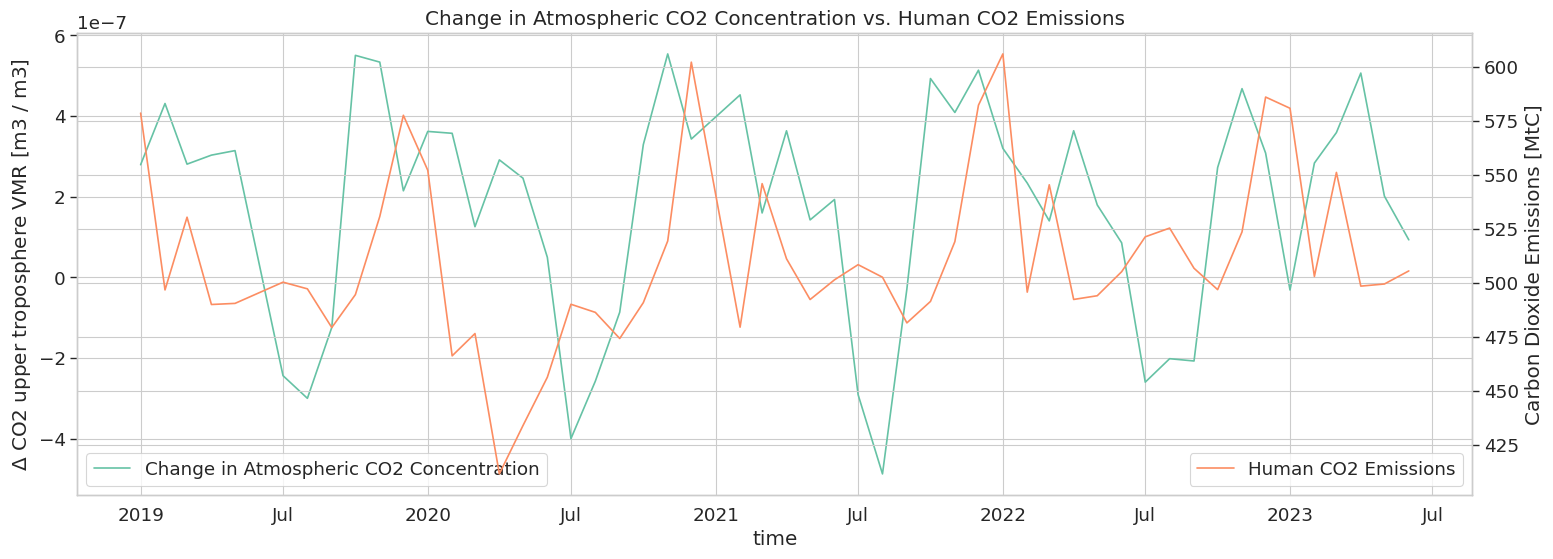

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
ax2 = ax.twinx()
palette = sns.color_palette("Set2", 2)

co2_airs.mean(dim="vertex").plot(ax=ax, label="Change in Atmospheric CO2 Concentration", c=palette[0])
(co2_graced.sum(dim="vertex") / 1000 / 1000 / 1000).plot(ax=ax2, label="Human CO2 Emissions", c=palette[1])
ax.legend()
ax2.legend(loc="lower right")

ax.set_title("Change in Atmospheric CO2 Concentration vs. Human CO2 Emissions")
ax2.set_title("")

ax.set_ylabel(rf"$\Delta$ {co2_airs.long_name} [{co2_airs.units}]")
ax2.set_ylabel(co2_graced.long_name + f" [MtC]")

fig.savefig(FIGURE_PATH / "over-time-alt.svg")

In [76]:
del co2_airs, co2_graced, co2_airs_diff, co2_graced_diff, ax, ax2, axs, axs2, fig, palette, attrs

## Emissions -> Concentration Network

In [6]:
co2_graced = concat_graced_data(5, method="sum")
co2_graced = mask_population(co2_graced, threshold=0)
co2_graced = hexgrid(co2_graced, method="sum", hex_res=3)
co2_graced = co2_graced.resample(time='1MS').sum(dim='time')
co2_graced = co2_graced.dropna("time", how="all")
#co2_graced = anomaly_correction_month(co2_graced)
co2_graced = (co2_graced - co2_graced.mean(dim="time")) / co2_graced.std(dim="time")

co2_airs = concat_airs_data()["co2_vmr_uppertrop"].sel(orbit_pass="13:30:00")
attrs = co2_airs.attrs.copy()
co2_airs = co2_airs.diff("time")
co2_airs.attrs = attrs
co2_airs = co2_airs.sel(time=co2_graced.time, method="nearest")
co2_airs = hexgrid(co2_airs, method="mean", hex_res=2)
#co2_airs = anomaly_correction_month(co2_airs)

Loading cached data from 
/home/tobias/Repositories/chaotic-carbon-networks/data/graced/cache/graced_co2_concat_5x_sumed.nc

Loading cached population data from 
/home/tobias/Repositories/chaotic-carbon-networks/data/population/cache/GHS_POP_E2020_GLOBE_R2023A_4326_30ss_V1_0_r
esampled_0.50deg.nc

Loading cached data from /home/tobias/Repositories/chaotic-carbon-networks/data/aqua-airs/cache/aqua_airs_concat.nc

In [7]:
m = mutual_information_matrix(co2_graced, co2_airs)

In [8]:
a = adjacency_matrix(m, rr=0.01)
ll = link_lengths_like(a)
avgll_graced = average_link_length(a, ll)
deg_graced = degrees(a)
avgll_airs = average_link_length(a, ll, dim="vertex")
deg_airs = degrees(a, dim="vertex")

Using a threshold of 2.0738518238067627 for the adjacency matrix

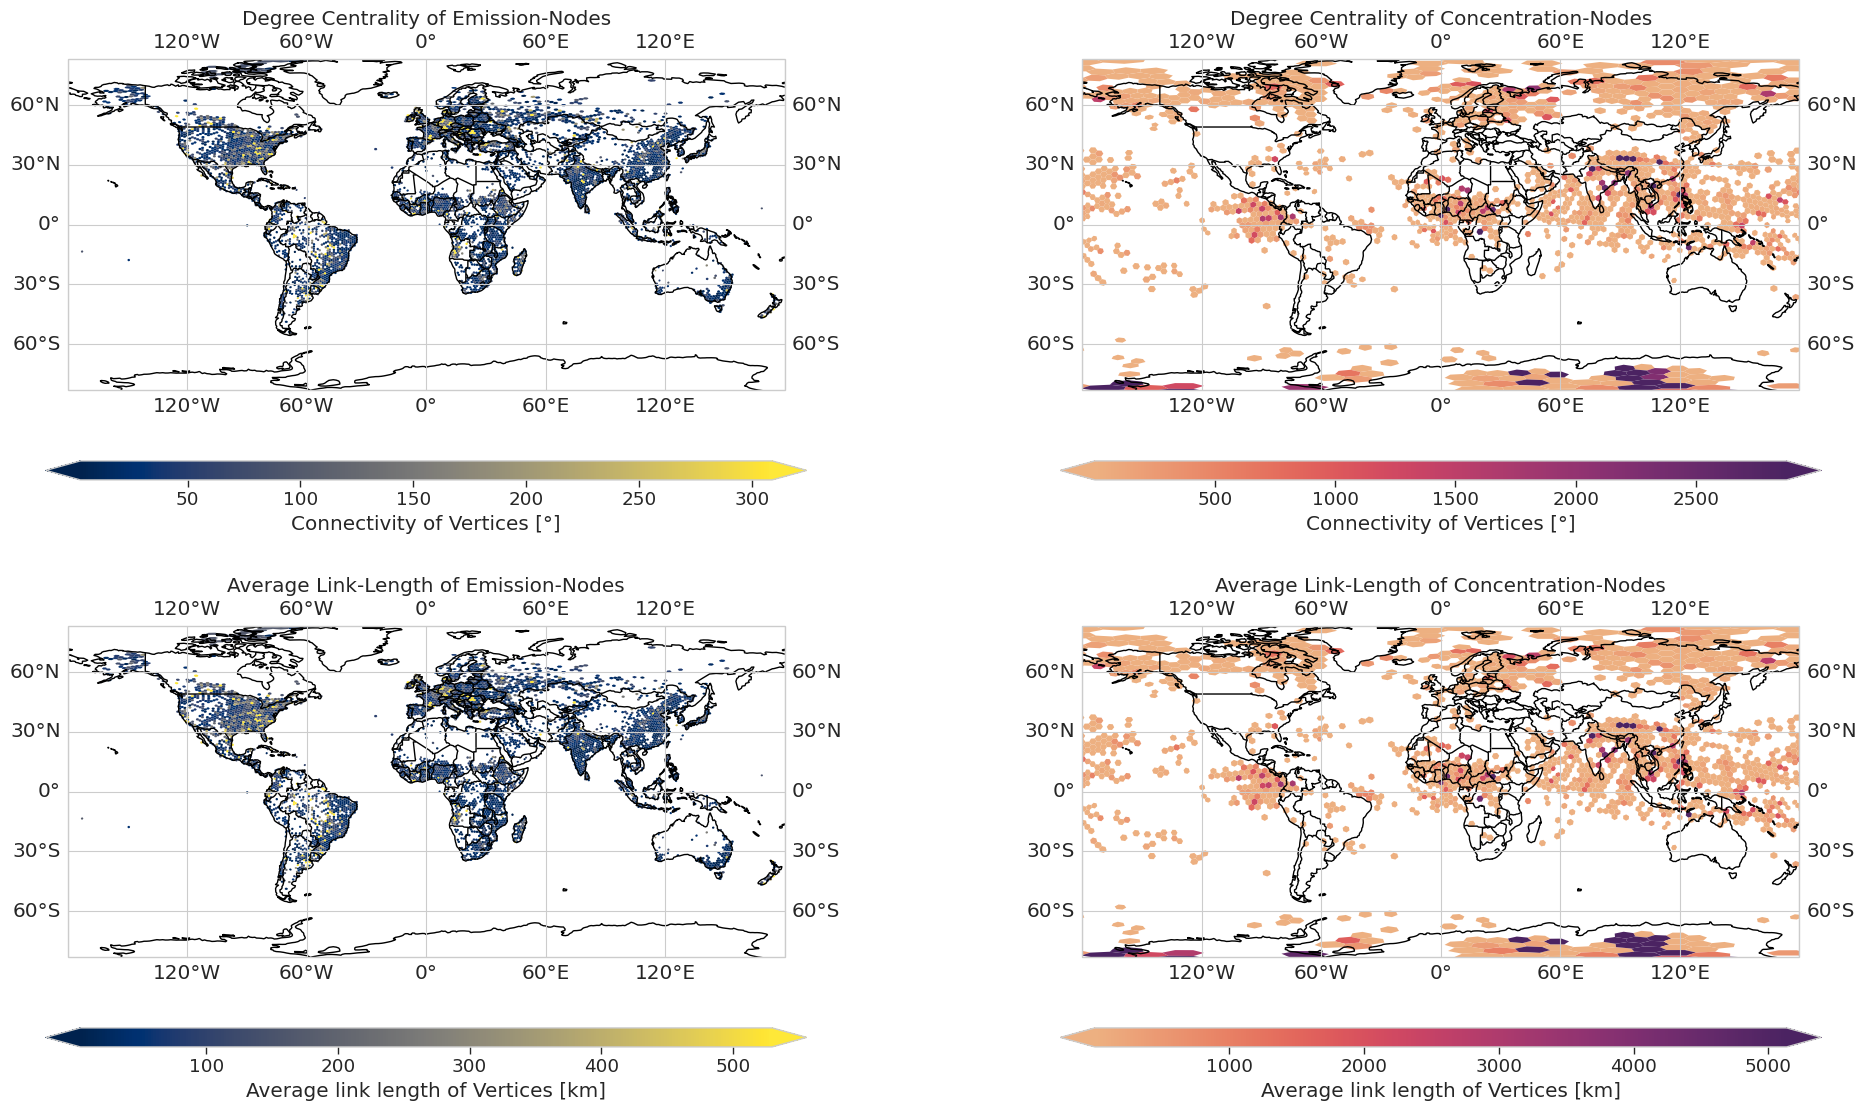

In [13]:
fig, axs = plt.subplots(2, 2,
                        sharey=True,
                        subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)},
                        figsize=(24, 13.5))
axs = axs.flatten()
plot_world_to_axis(deg_graced.where(deg_graced > 0).dropna("vertex"), axs[0], cmap="cividis")
plot_world_to_axis(deg_airs.where(deg_airs > 0).dropna("vertex"), axs[1], cmap="flare")
plot_world_to_axis(avgll_graced.where(avgll_graced > 0).dropna("vertex"), axs[2], cmap="cividis")
plot_world_to_axis(avgll_airs.where(avgll_airs > 0).dropna("vertex"), axs[3], cmap="flare")


axs[0].set_title("Degree Centrality of Emission-Nodes")
axs[1].set_title("Degree Centrality of Concentration-Nodes")
axs[2].set_title("Average Link-Length of Emission-Nodes")
axs[3].set_title("Average Link-Length of Concentration-Nodes")

fig.savefig(FIGURE_PATH / "emissions-to-concentrations-network.svg")
fig.savefig(FIGURE_PATH / "emissions-to-concentrations-network.jpg")

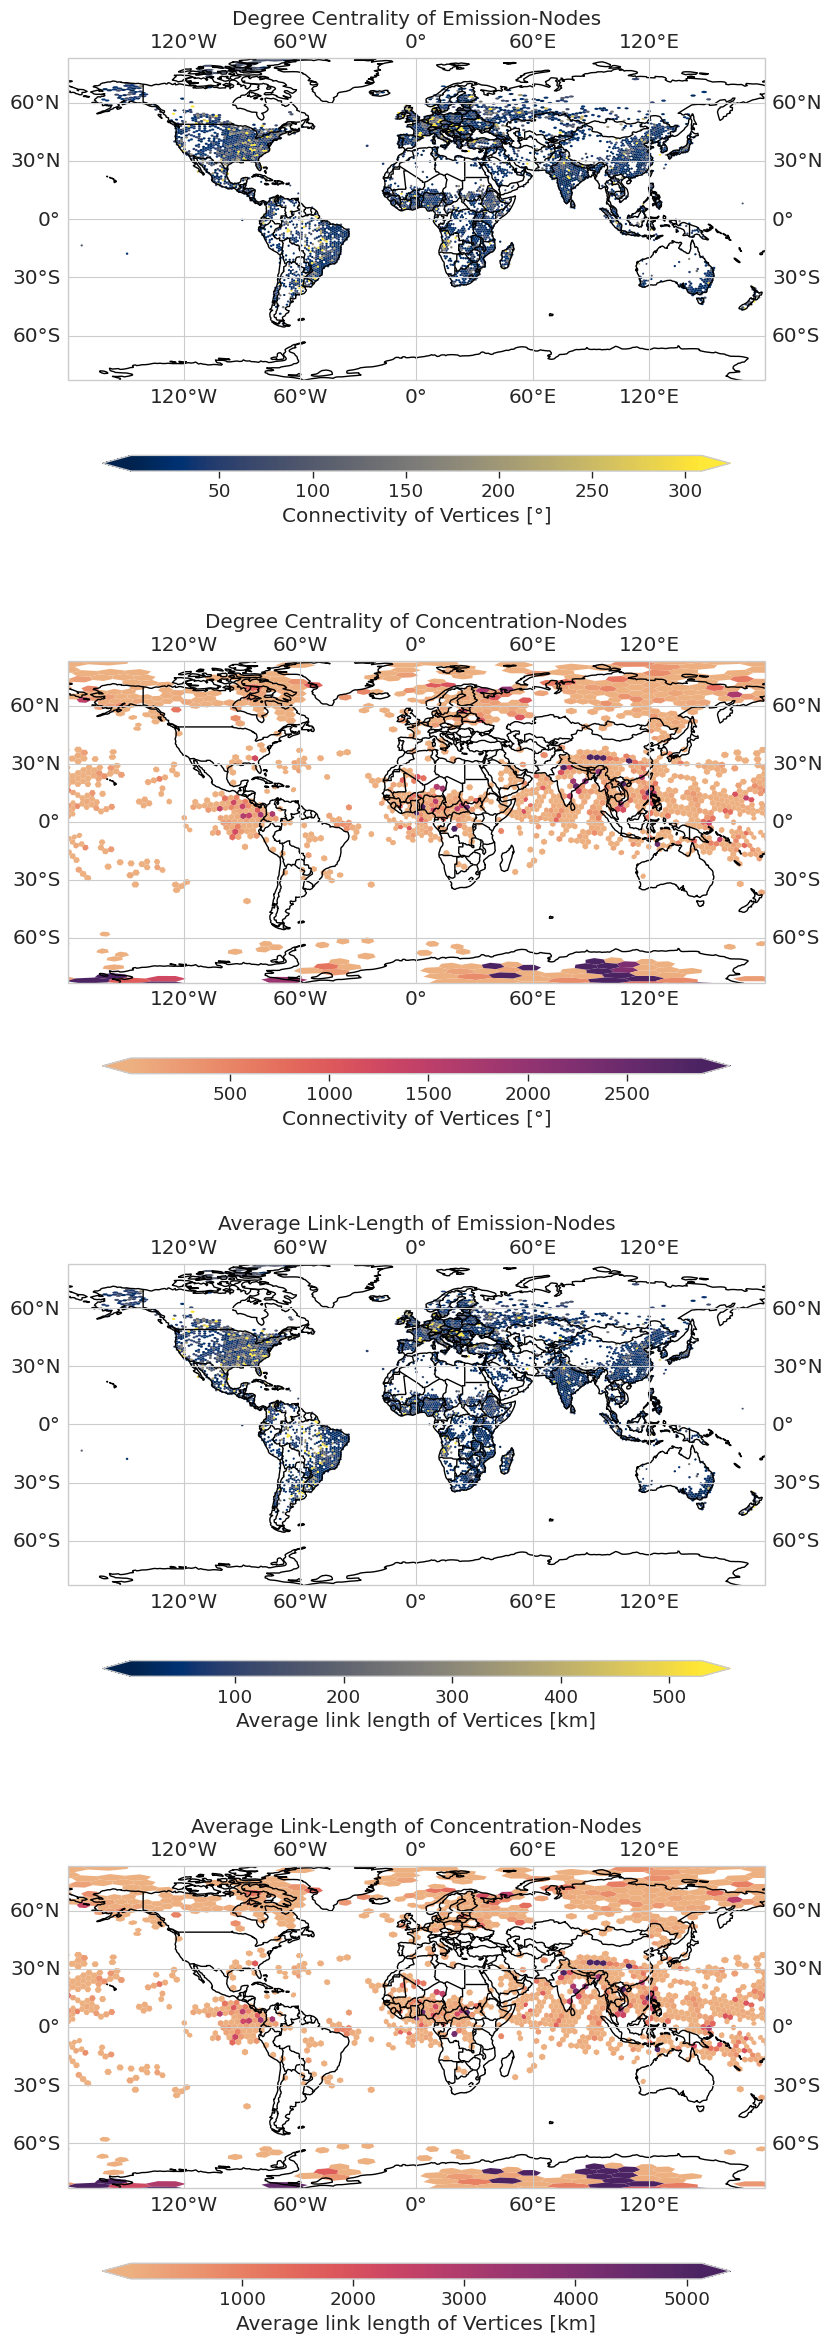

In [12]:
fig, axs = plt.subplots(4, 1,
                        sharey=True,
                        subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)},
                        figsize=(9, 30))
axs = axs.flatten()
plot_world_to_axis(deg_graced.where(deg_graced > 0).dropna("vertex"), axs[0], cmap="cividis")
plot_world_to_axis(deg_airs.where(deg_airs > 0).dropna("vertex"), axs[1], cmap="flare")
plot_world_to_axis(avgll_graced.where(avgll_graced > 0).dropna("vertex"), axs[2], cmap="cividis")
plot_world_to_axis(avgll_airs.where(avgll_airs > 0).dropna("vertex"), axs[3], cmap="flare")


axs[0].set_title("Degree Centrality of Emission-Nodes")
axs[1].set_title("Degree Centrality of Concentration-Nodes")
axs[2].set_title("Average Link-Length of Emission-Nodes")
axs[3].set_title("Average Link-Length of Concentration-Nodes")

fig.savefig(FIGURE_PATH / "emissions-to-concentrations-network-col.svg")
fig.savefig(FIGURE_PATH / "emissions-to-concentrations-network-col.jpg")

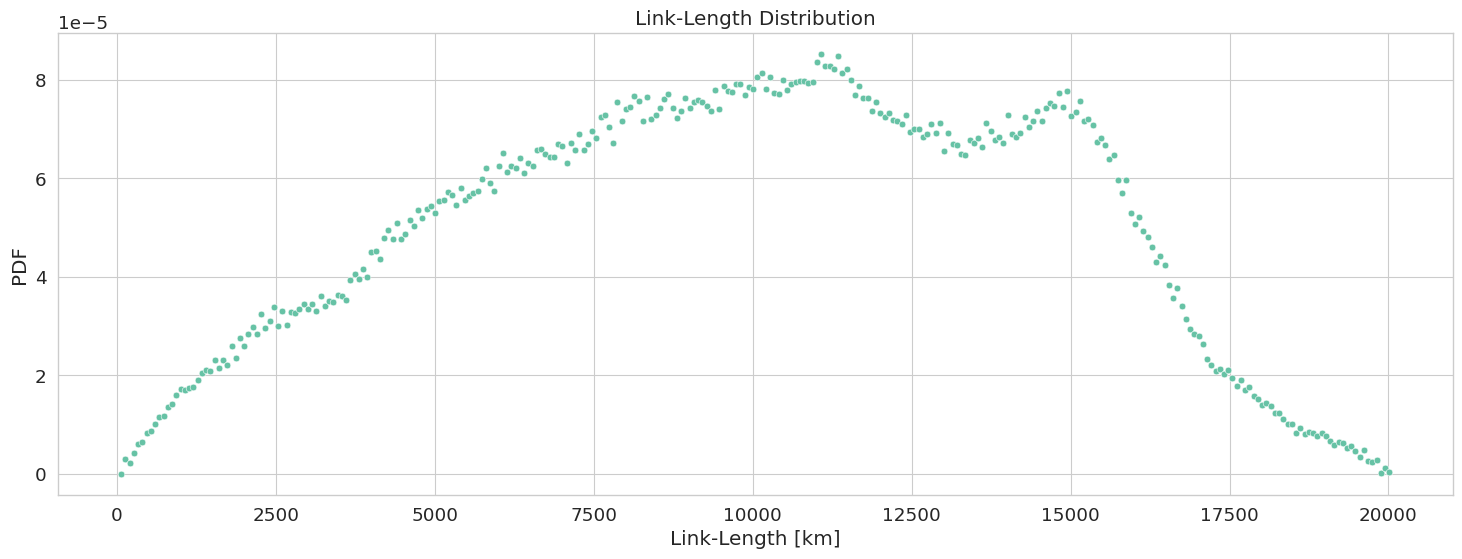

In [279]:
lla = a * ll
ncount, bins = np.histogram(lla.values, bins=300, range=(1, lla.max().item()), density=True)
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
sns.scatterplot(x=bins[1:], y=ncount, ax=ax)
ax.set_title("Link-Length Distribution")
ax.set_xlabel("Link-Length [km]")
ax.set_ylabel("PDF")

fig.savefig(FIGURE_PATH / "link-length-distribution.svg")

In [154]:
del fig, axs, m, a, ll, lla, avgll_airs, avgll_graced, deg_airs, deg_graced, co2_airs, co2_graced